##1. Load the data


In [1]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-01-06 18:42:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.3MB/s    in 5.5s    

2023-01-06 18:42:21 (18.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [2]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img
     

Image shape: (512, 384, 3)
Image shape: (512, 512, 3)


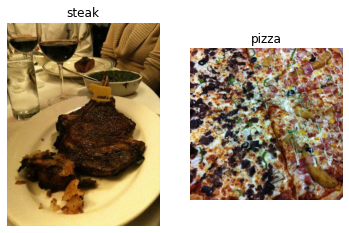

In [3]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image(train_dir, "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image(test_dir, "pizza")

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create train and test data generators and rescale the data
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [5]:
# Load the images from directory & turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               batch_size=32)
test_data = train_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [6]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [7]:
# Check lengths of training and test data generators
print("Check the batches:")
print()
print(f"1500/32 appriximately: {len(train_data)}")
print(f"500/32 approximately: {len(test_data)}")

Check the batches:

1500/32 appriximately: 47
500/32 approximately: 16


##2. Create a model (start with a baseline)

In [8]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [9]:
model_1 = Sequential([
    Conv2D(filters=10,#these are the number of "feature extractors" that will be moving over our images.
           kernel_size=3,
           strides=1, #the number of pixels a filter will move across as it covers the image. 
           padding='valid',#this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input
           activation='relu',
           input_shape=(224,224,3)),
     Conv2D(10, 3, activation='relu'),
     Conv2D(10, 3, activation='relu'),
     Flatten(),
     Dense(1, activation = 'sigmoid') #since we are in binary classification
])

model_1.compile(loss = 'binary_crossentropy', #since we are in binary classification
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))
#here we dont need to write explicitly X_train and y_train

Epoch 1/5
47/47 [==============================] - 19s 214ms/step - loss: 0.9070 - accuracy: 0.5900 - val_loss: 0.5964 - val_accuracy: 0.7280
Epoch 2/5
47/47 [==============================] - 10s 212ms/step - loss: 0.4531 - accuracy: 0.8040 - val_loss: 0.3991 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 9s 193ms/step - loss: 0.2952 - accuracy: 0.8847 - val_loss: 0.3642 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 9s 195ms/step - loss: 0.1247 - accuracy: 0.9533 - val_loss: 0.4280 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 9s 195ms/step - loss: 0.0521 - accuracy: 0.9880 - val_loss: 0.6428 - val_accuracy: 0.7840


In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 dense (Dense)               (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


##3. Evaluate the model

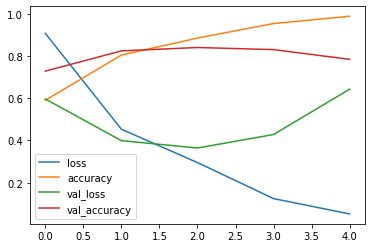

In [15]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

If we look to training loss and validation loss, after a point validation loss starts to increase whereas training loss decrease. It seems like model is overfitting. 

In order to see difference more clearly lets create seperate loss and accuracy curves.

In [56]:
def plot_loss_curves(history):

  epochs = range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs,history.history['loss'], label='training_loss')
  plt.plot(epochs,history.history['val_loss'], label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()

  #plot accuracy
  plt.plot(epochs,history.history['accuracy'], label='training_accuracy')
  plt.plot(epochs,history.history['val_accuracy'], label='validation_accuracy')
  plt.title('accuracy')
  plt.xlabel('Epochs')
  plt.legend();


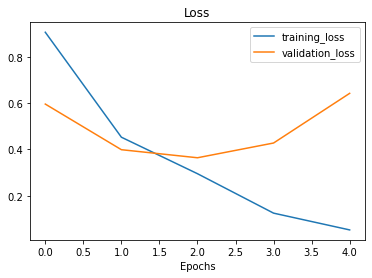

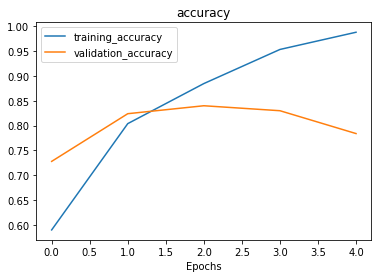

In [57]:
plot_loss_curves(history_1)

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 dense (Dense)               (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


##4. Adjusting parameters

In order to increase overfitting:

* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

In order to reduce overfitting:

* Get more data.
* Simplify model.
* Data aumentation.
* Transfer learning

Lets adjust the number of parameters via maxpooling and data augmentation.

In [21]:
model_2 = Sequential([
    Conv2D(10, 3, activation='relu',input_shape=(224,224,3)),
    MaxPool2D(pool_size=2), #reduce number of features by half
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(units=1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),)

Epoch 1/5
47/47 [==============================] - 14s 284ms/step - loss: 0.5508 - accuracy: 0.7200 - val_loss: 0.4194 - val_accuracy: 0.8220
Epoch 2/5
47/47 [==============================] - 9s 187ms/step - loss: 0.4236 - accuracy: 0.8187 - val_loss: 0.3588 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 9s 187ms/step - loss: 0.3649 - accuracy: 0.8427 - val_loss: 0.3209 - val_accuracy: 0.8760
Epoch 4/5
47/47 [==============================] - 9s 187ms/step - loss: 0.3454 - accuracy: 0.8600 - val_loss: 0.3019 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 9s 186ms/step - loss: 0.2928 - accuracy: 0.8827 - val_loss: 0.3060 - val_accuracy: 0.8700


In [22]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 29160)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                

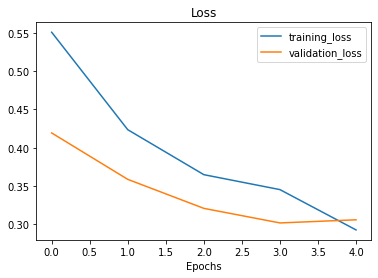

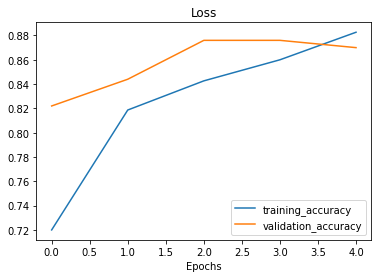

In [23]:
plot_loss_curves(history_2)

It seems overfitting is reduced but in the end of loss curve, validation loss starts to increase.

This time lets use data augmentation.

This makes the model forced to try and learn patterns in less-than-perfect images, which is often the case.

In [24]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)


In [51]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')
     

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


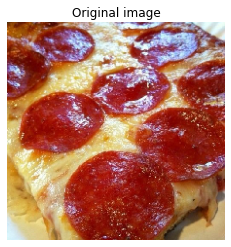

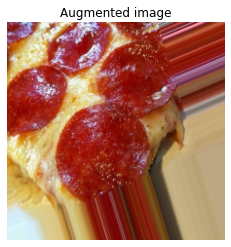

In [52]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same
  

# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)

plt.figure()

plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);


In [53]:
# I did not shuffled train data in order to see images. Lets now shuffle the data

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

Found 1500 images belonging to 2 classes.


In [54]:
model_3 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_3 = model_3.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 23s 470ms/step - loss: 0.6904 - accuracy: 0.4987 - val_loss: 0.6653 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 21s 457ms/step - loss: 0.6395 - accuracy: 0.6007 - val_loss: 0.5601 - val_accuracy: 0.7280
Epoch 3/5
47/47 [==============================] - 22s 459ms/step - loss: 0.5724 - accuracy: 0.7020 - val_loss: 0.4540 - val_accuracy: 0.8000
Epoch 4/5
47/47 [==============================] - 22s 458ms/step - loss: 0.5425 - accuracy: 0.7420 - val_loss: 0.4200 - val_accuracy: 0.8160
Epoch 5/5
47/47 [==============================] - 22s 477ms/step - loss: 0.4824 - accuracy: 0.7767 - val_loss: 0.3303 - val_accuracy: 0.8580


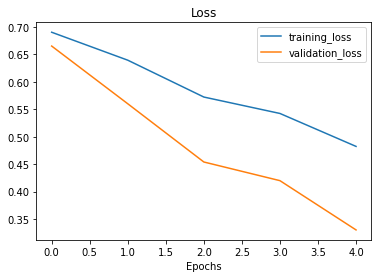

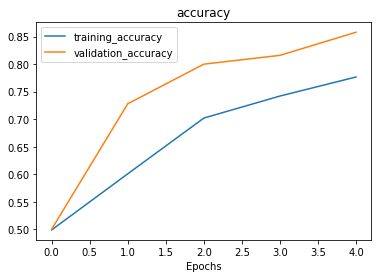

In [58]:
plot_loss_curves(history_3)

## 5. Imroving the model

Now we can do few more things:

* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Create early stopping mechanism.
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use transfer learning to leverage what another image model has learned and adjust it for our own use case.

In [59]:
from keras.callbacks import EarlyStopping
# Create a learning rate scheduler callback
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

#importin early stopping mecanism
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

Lets increase convolutional layers and use tinyVGG architecture.

Since I worked on early stopping mechanism several times I decided to continue with 5 epoch. Also, since I worked on lr_scedular mechanism and cant find any considerible resulti I commented it.

If there were a considerable result, we would just plot:

* pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

and find the optimum point.

In [72]:
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_4 = model_4.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[es])

Epoch 1/5
47/47 [==============================] - 23s 475ms/step - loss: 0.6537 - accuracy: 0.6007 - val_loss: 0.4878 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 23s 490ms/step - loss: 0.5311 - accuracy: 0.7447 - val_loss: 0.3968 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 27s 574ms/step - loss: 0.5041 - accuracy: 0.7647 - val_loss: 0.4018 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 25s 532ms/step - loss: 0.4993 - accuracy: 0.7600 - val_loss: 0.3716 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 27s 569ms/step - loss: 0.4636 - accuracy: 0.7767 - val_loss: 0.3350 - val_accuracy: 0.8520


## 6. Making Prediction

In [73]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

--2023-01-06 21:18:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.01s   

2023-01-06 21:18:51 (183 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



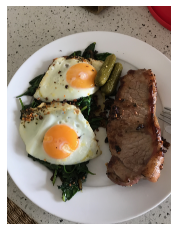

In [65]:
"""# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);"""

In [74]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [75]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  # Since our model trained in batches, batch_size becomes the first dimension.
  # (batch_size,224,224,3)
  # Therefore we need to add extra dimension.
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)
  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

--2023-01-06 21:41:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M  --.-KB/s    in 0.02s   

2023-01-06 21:41:09 (115 MB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]

1/1 [==============================] - 0s 60ms/step
[[0.8575296]]


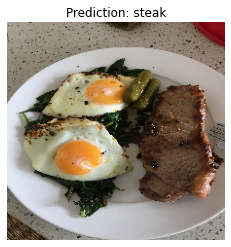

In [76]:
# Test our model on a custom image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
pred_and_plot(model_4, "03-steak.jpeg", class_names)